## Importing Required Libraries
This section imports the necessary libraries and modules for building and training a deep learning model for image processing. Key components include:
- `matplotlib.pyplot` for data visualization.
- `numpy` for numerical operations.
- `cv2` for computer vision tasks.
- `tensorflow` and Keras modules for building and training neural networks.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras.models import load_model


## Loading License Plate Detection Data
This section initializes the Haar Cascade classifier using OpenCV for license plate detection. The cascade file (`indian_license_plate.xml`) contains pre-trained data required for identifying license plates in images.


In [ ]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/major_project/indian_license_plate.xml")
# add the path to 'india_license_plate.xml' file.

## Defining the License Plate Detection Function
This section defines the `detect_plate` function, which performs the following tasks:
- Detects license plates in the input image using the Haar Cascade classifier.
- Draws bounding rectangles around detected plates.
- Optionally adds text near the detected plate.
- Returns the processed image with annotations and the cropped plate region.


In [ ]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7)
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3)
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)

    return plate_img, plate # returning the processed image.

## Testing the License Plate Detection Function
This section:
- Defines a helper function `display` to visualize images using Matplotlib by converting them from BGR to RGB.
- Loads a sample image (`car2.jpg`) for testing the detection function.
- Detects the license plate in the image using the `detect_plate` function and extracts the plate region.
- Displays the processed image with the detected license plate highlighted.


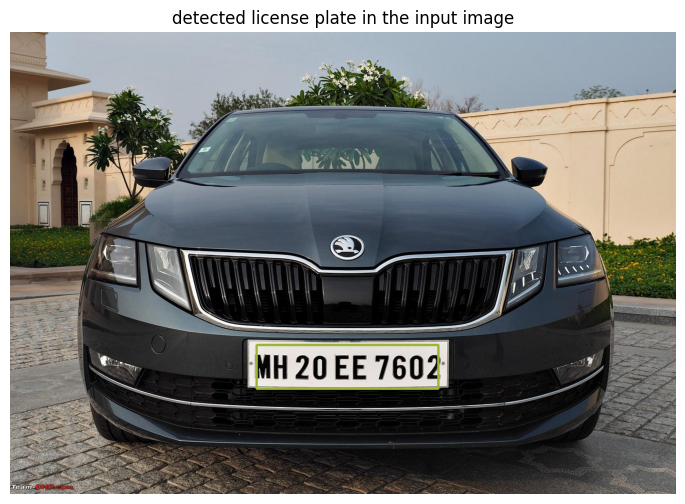

In [ ]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread("/content/drive/MyDrive/major_project/car2.jpg")
# Getting plate prom the processed image
output_img, plate = detect_plate(img)
display(output_img, 'detected license plate in the input image')

## Defining the Contour Matching Function
This section introduces the `find_contours` function, which performs the following steps:
- Detects contours in a binary image using OpenCV's `findContours` method.
- Filters contours based on the specified width and height dimensions to identify potential license plate characters.
- Sorts contours based on their `x`-coordinates to maintain the correct character order.
- Processes and resizes each detected character to a standard size (24x44) with padding for consistent formatting.
- Returns a sorted array of processed character images, ready for further classification or recognition.


In [ ]:

# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)
            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)

    #Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

## Segmenting Characters from the License Plate
This section defines the `segment_characters` function, which extracts individual characters from a cropped license plate image. Key steps include:
1. **Preprocessing the Image**:
   - Resizing the license plate image to a fixed dimension (333x75).
   - Converting the image to grayscale and applying binary thresholding.
   - Performing erosion and dilation to enhance the character regions.

2. **Adjusting Borders**:
   - Adding white borders to the image for better contour detection.

3. **Defining Character Dimensions**:
   - Estimating typical dimensions for license plate characters based on the plate size.

4. **Contour Detection**:
   - Calling the `find_contours` function to locate and extract individual characters.

5. **Returning Character List**:
   - Outputs a list of segmented characters ready for recognition.


In [ ]:
# Find characters in the resulting images

def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

## Visualizing Segmented Characters
This section segments the characters from the detected license plate and visualizes them:
- Calls the `segment_characters` function to extract individual characters from the license plate image.
- Uses Matplotlib to display the first 10 segmented characters in a single row without axes.
- Each subplot represents one character, allowing for quick verification of the segmentation process.


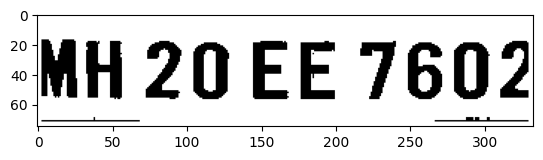

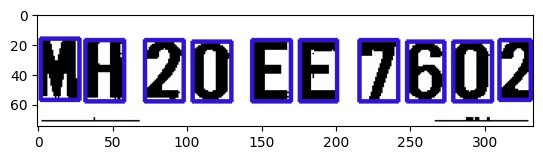

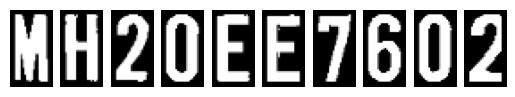

In [ ]:
char = segment_characters(plate)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

## Enabling Eager Execution in TensorFlow
This section enables eager execution using TensorFlow's `tf.compat.v1.enable_eager_execution()`:
- Eager execution allows operations to be executed immediately as they are called within Python, making debugging and development simpler and more intuitive.
- Useful for dynamic workflows and interactive environments like Jupyter notebooks.


In [ ]:
tf.compat.v1.enable_eager_execution()

## Preparing Image Data for Training and Validation
This section uses the `ImageDataGenerator` class to preprocess images for training and validation:
- **Data Augmentation**:
  - Rescales pixel values to a range of [0, 1] by dividing by 255.
  - Applies random width and height shifts for augmentation.
  
- **Training Data Generator**:
  - Loads images from the specified training directory.
  - Resizes all images to 28x28.
  - Generates batches of size 1 with categorical labels.

- **Validation Data Generator**:
  - Loads images from the validation directory.
  - Resizes all images to 28x28.
  - Generates batches of size 1 with categorical labels.

These generators streamline the image preprocessing pipeline for model training and validation.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        "/content/drive/MyDrive/major_project/data/data/data/train",  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        "/content/drive/MyDrive/major_project/data/data/data/val",  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


## Building and Training the Convolutional Neural Network (CNN)
This section defines and trains a CNN model for character recognition on the segmented license plate images:

1. **Model Architecture**:
   - **Conv2D Layer**: Adds a 2D convolutional layer with 32 filters, a 24x24 kernel size, ReLU activation, and 'same' padding.
   - **MaxPooling2D Layer**: Reduces spatial dimensions using a 2x2 pooling size.
   - **Dropout Layer**: Regularizes the model by randomly dropping 40% of neurons during training to prevent overfitting.
   - **Flatten Layer**: Flattens the 2D output into a 1D vector for the dense layers.
   - **Dense Layers**: Fully connected layers with 128 neurons and ReLU activation, followed by a final layer with 36 neurons (for 36 possible characters) and softmax activation.

2. **Model Compilation**:
   - The model is compiled with categorical crossentropy loss, Adam optimizer with a very low learning rate (0.00001), and accuracy as the metric.

3. **Training Callbacks**:
   - **StopTrainingCallback**: Stops training if the validation accuracy exceeds 99%.
   - **TensorBoard Callback**: Logs training data for visualization in TensorBoard.

4. **Model Training**:
   - The model is trained on the training generator with the validation generator, for up to 80 epochs, and logs are saved for later analysis.

This setup ensures efficient training with early stopping and detailed logging for performance analysis.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

from tensorflow.keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Use the correct metric key
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.99:
            print(f"\nStopping training as validation accuracy has reached {logs.get('val_accuracy'):.3f}")
            self.model.stop_training = True

import os
import shutil
import datetime
# Remove the logs directory if it exists (cross-platform)
if os.path.exists("logs"):
    shutil.rmtree("logs")

# Set up the log directory with the current timestamp
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print(f"TensorBoard logs will be saved in: {log_dir}")

batch_size = 1
callbacks = [tensorboard_callback, StopTrainingCallback()]
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs = 80, callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorBoard logs will be saved in: logs/fit/20241126-055011
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


863/864 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.0560 - loss: 3.5733

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


864/864 ━━━━━━━━━━━━━━━━━━━━ 488s 559ms/step - accuracy: 0.0561 - loss: 3.5731 - val_accuracy: 0.1713 - val_loss: 3.3843
Epoch 2/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1944 - val_loss: 3.3774
Epoch 3/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.1806 - loss: 3.2949 - val_accuracy: 0.3889 - val_loss: 2.9322
Epoch 4/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4120 - val_loss: 2.9229
Epoch 5/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.3075 - loss: 2.7929 - val_accuracy: 0.5694 - val_loss: 2.3663
Epoch 6/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5463 - val_loss: 2.3241
Epoch 7/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.4262 - loss: 2.3021 - val_accuracy: 0.6528 - val_loss: 1.9522
Epoch 8/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss

## Saving the Trained Model
This section saves the trained model to a file:
- The model is saved in H5 format using the `model.save()` function, which allows for easy loading and deployment later.
- The saved model is named "ocr_model.h5", ensuring the trained model is stored with a clear identifier.


In [ ]:
# Save the model in H5 format
model.save("ocr_model.h5")
print("Model saved as 'trained_model.h5'")

Model saved as 'trained_model.h5'


## Launching TensorBoard for Model Visualization
This section launches TensorBoard to visualize training metrics:
- The `%load_ext tensorboard` command loads the TensorBoard extension in the Jupyter notebook environment.
- The `%tensorboard --logdir logs/fit --port 8080` command starts the TensorBoard server, pointing it to the logs directory where training data is saved.
- TensorBoard will be accessible via the specified port (8080), providing interactive visualizations of metrics such as loss, accuracy, and more.


In [ ]:
# !kill 16376
%load_ext tensorboard
%tensorboard --logdir logs/fit --port 8080

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
2024-11-26 06:23:42.362475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 06:23:42.395018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 06:23:42.405013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 06:23:44.124499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorfl

In [ ]:
#!tasklist | findstr tensorboard
#!taskkill /PID <PID> /F

## Predicting License Plate Characters
This section defines a function to predict the license plate number using the trained model:

1. **Fixing Image Dimensions**:
   - The `fix_dimension` function ensures the input image has the correct shape by replicating the grayscale image across three color channels (RGB), as the model expects a 3-channel input.

2. **Character Prediction**:
   - The `show_results` function iterates over the segmented characters, resizes each to 28x28 pixels, and reshapes them to match the model's expected input shape.
   - The image is then fed into the trained model to predict the character class.
   - The predicted class is mapped back to the corresponding character (from '0' to '9' and 'A' to 'Z').

3. **Final Plate Number**:
   - The predicted characters are concatenated to form the complete license plate number.

This setup uses the model to predict the license plate number from the segmented characters.


In [ ]:
# Predicting the output
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c
    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation = cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)#reparing image for the model
        y_ = model.predict(img)[0]
        classes_x = np.argmax(y_)
        character = dic[classes_x]
        output.append(character) #storing the result in a list

    plate_number = ''.join(output)

    return plate_number

print(show_results())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
MH20EE7602


## Displaying Predicted Characters with Images
This section visualizes the segmented characters along with their predicted labels:

1. **Figure Setup**:
   - The `plt.figure(figsize=(10,6))` command creates a figure with a size of 10x6 inches for better readability.
   
2. **Subplots for Each Character**:
   - A loop iterates over the segmented characters (stored in the `char` list).
   - Each character is resized to 28x28 pixels to match the model's input size.
   - The `plt.subplot(3,4,i+1)` command places each resized character in a grid layout with 3 rows and 4 columns.

3. **Predicted Character Display**:
   - The `plt.imshow(img, cmap='gray')` command displays each resized character in grayscale.
   - The predicted character for each segment is displayed in the subplot title using `plt.title(f'predicted: {show_results()[i]}')`.

4. **Display the Plot**:
   - `plt.show()` displays the plot, showing the segmented characters with their corresponding predictions.

This visualization helps verify the accuracy of the character recognition by comparing each predicted label with the visualized character.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

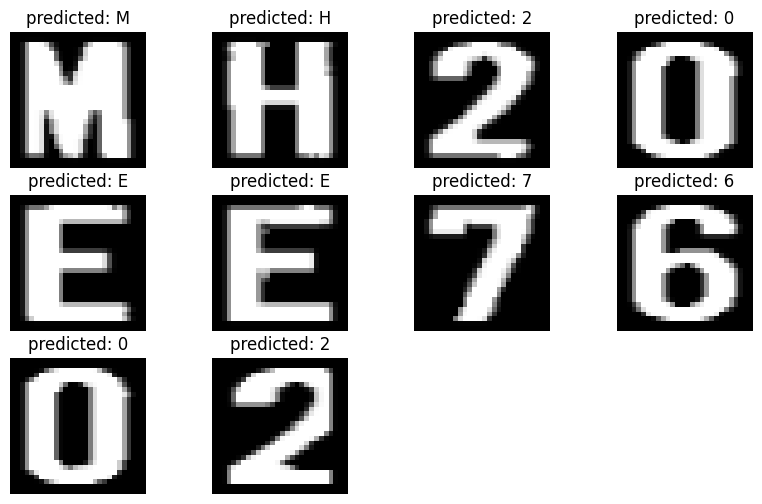

In [ ]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## Displaying the License Plate Number on the Image
This section adds the detected license plate number to the image:

1. **Setting Text Parameters**:
   - The `plate_number` is fetched using the `show_results()` function.
   - `plate_position` sets the position where the plate number will be displayed on the image (coordinates are (100, 400)).
   - Font properties such as `font`, `font_scale`, and `font_thickness` are defined to ensure the plate number is displayed in a large and readable font.
   - `text_color` is set to green `(0, 255, 0)` for visibility against the image background.

2. **Adding Text to the Image**:
   - `cv2.putText(output_image, plate_number, plate_position, font, font_scale, text_color, font_thickness, cv2.LINE_AA)` adds the license plate number as text to the image at the specified position.

3. **Displaying the Image**:
   - The image with the overlayed plate number is converted to RGB format (`cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)`) for correct display in `matplotlib`.
   - `plt.imshow(...)` displays the image, and `plt.show()` renders it with the title "Detected License Plate Number with Larger Font Size" and no axis visible.

This allows for a clearer and more visible presentation of the license plate number on the image.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


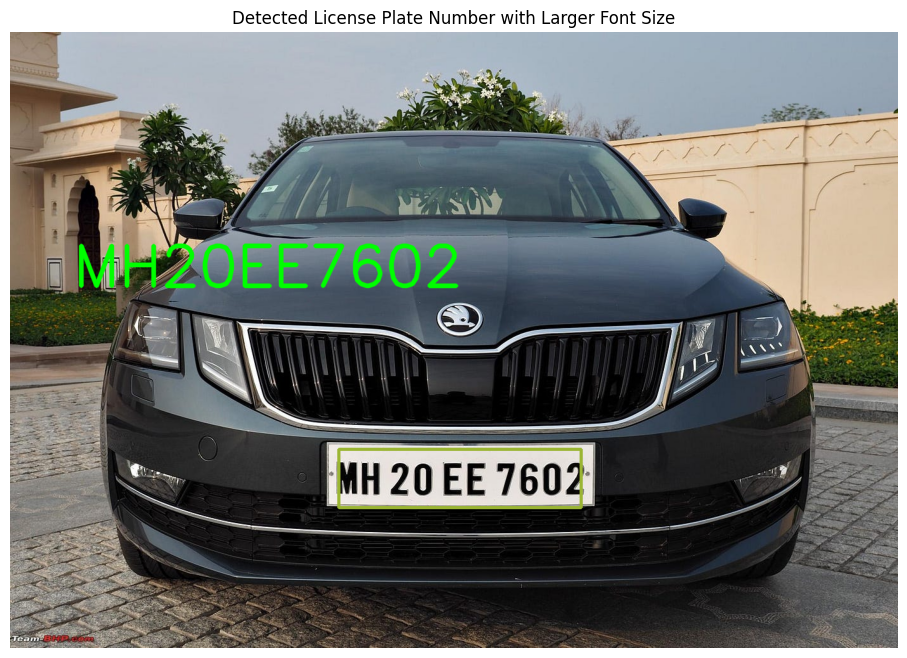

In [ ]:
# # Define the plate number and its position
plate_number = show_results()
plate_position = (100, 400)  # Position to display the text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 3  # Larger font scale for the plate number
font_thickness = 5  # Thicker font for better visibility
text_color = (0, 255, 0)  # Green color for the text

# # Add the plate number text to the image
output_image = output_img.copy()
cv2.putText(output_image, plate_number, plate_position, font, font_scale, text_color, font_thickness, cv2.LINE_AA)

# # Display the modified output image
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_image ,cv2.COLOR_BGR2RGB))
plt.title("Detected License Plate Number with Larger Font Size")
plt.axis("off")
plt.show()


## Loading the Pre-trained Model
This section loads the trained model from the saved `.h5` file:

1. **Loading the Model**:
   - `loaded_model = load_model("trained_model.h5")` loads the model that was previously trained and saved as `trained_model.h5`.
   - If the model is loaded successfully, the message `Model loaded successfully!` is printed.

This allows for the reuse of the trained model in further predictions or evaluations without needing to retrain it.


In [ ]:
loaded_model = load_model("trained_model.h5")
print("Model loaded successfully!")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'trained_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Model Evaluation on Validation Dataset

This section evaluates the performance of the trained OCR model on the validation dataset using various metrics:

1. **Data Generators**:
   - `train_datagen` and `validation_datagen` are used to preprocess the training and validation datasets, respectively, by rescaling images and applying augmentation (for training data).
   
2. **Loading Datasets**:
   - `train_generator` loads the training data from the specified directory and resizes images to 28x28 pixels.
   - `validation_generator` loads the validation data similarly but ensures that the data is not shuffled to preserve the order for evaluation.

3. **Loading the Model**:
   - The model is loaded from the `ocr_model.h5` file using `load_model()`.

4. **Generating Predictions**:
   - The model predicts the classes for the validation dataset using `model.predict()`.
   - The predictions are converted to class indices using `np.argmax()`.

5. **Evaluation Metrics**:
   - The following metrics are computed:
     - **Accuracy**: The proportion of correct predictions.
     - **Precision**: The weighted average of precision for each class.
     - **Recall**: The weighted average of recall for each class.
     - **F1 Score**: The weighted average of the F1 score for each class.
   - `classification_report()` provides detailed performance metrics for each class.

6. **Results**:
   - The accuracy, precision, recall, and F1 score are printed.
   - A detai


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Define data generators for train and validation datasets
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load train and validation datasets
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/major_project/data/data/data/train",
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    "/content/drive/MyDrive/major_project/data/data/data/val",
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Load the trained model
model = load_model("ocr_model.h5")
print("Model loaded successfully.")

# Get predictions on the validation dataset
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples, verbose=1)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Evaluate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


Model loaded successfully.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Accuracy: 0.9861
Precision: 0.9891
Recall: 0.9861
F1 Score: 0.9858

Classification Report:
              precision    recall  f1-score   support

     class_0       0.75      1.00      0.86         6
     class_1       1.00      1.00      1.00         6
     class_2       1.00      1.00      1.00         6
     class_3       1.00      1.00      1.00         6
     class_4       1.00      1.00      1.00         6
     class_5       1.00      1.00      1.00         6
     class_6       1.00      1.00      1.00         6
     class_7       1.00      1.00      1.00         6
     class_8       1.00      1.00      1.00         6
     class_9       1.00      1.00      1.00         6
     class_A       1.00      1.00      1.00         6
     class_B       1.00      1.00      1.00         6
     class_C       1.00      1.00      1.00         6
     class_D       1.00      1.00      1.00         6
     class_E       1.00      1.00      1.00         6
  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')